# Импортируем все библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, UpSampling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, Lambda, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Сделаем генераторы

In [2]:
def tf_generator(gen_df: pd.DataFrame, batch_size: int):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            idx = np.random.randint(0, len(imagePath_df))
    
            image = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['images'].iloc[idx])
            mask = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['masks'].iloc[idx])
            mask[mask == 255] = 1
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

            x_batch += [image]
            y_batch += [mask]
        
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [3]:
def plot_images(imagePath_df: pd.DataFrame):
    idx = np.random.randint(0, len(imagePath_df))
    
    image = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['images'].iloc[idx])
    mask = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['masks'].iloc[idx])
    mask[mask == 255] = 1
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    fig, axs = plt.subplots(1, 3, figsize=[13, 15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

In [4]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# Выгрузка данных и анализ

## Загрузим и просмотрим расположения файлов

In [5]:
DataPath = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
class_ = []
for dirname, _, filenames in tqdm(os.walk(DataPath)):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append("/kaggle/input/lgg-mri-segmentation/kaggle_3m/" + dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
            mask = cv2.imread("/kaggle/input/lgg-mri-segmentation/kaggle_3m/" + dirname.replace(DataPath, '') + '/' + filename)
            mask[mask == 255] = 1
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            class_.append(1 if mask.sum() > 0 else 0)

111it [00:42,  2.64it/s]


In [6]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks, 'class': class_})

In [7]:
imagePath_df

directory  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                            images                              masks  class  
0     TCGA_DU_7010_19860307_56.tif  TCGA_DU_7010_19860307_56_mask.tif      0  
1      TCGA_DU_7010_19860307_8.tif   TCGA_DU_7010_19860307_8_mask.tif      0  
2     TCGA_DU_7010_19860307_34.tif  TCGA_DU_7010_19860307_34_mask.tif      1  
3     TCGA_DU_7010_19860307_33.tif  TCGA_DU_7010_19860307_33_mask.tif      1  
4     TCGA_DU_7010_19860307_43.tif  TCGA_DU_7010_19860307_43_mask.tif      1  
...                            ...                                ...    ...  
3924  TCGA_DU_7306_19930512_14.tif  TCGA_DU_7306_19930512_14_mask.tif      0  
3925  TCGA_DU_7306_19930512_42.tif  TCGA_DU_7306_19930512_42_mask.tif      0  
3926  TCGA_DU_7306_19930512_29.tif  TCGA_DU_7306_19930512_29_mask.tif      0  
3927  TCGA_DU_7306_19930512_10.tif  TCGA_DU_7306_19930512_10_mask.tif      0  
3928  TCGA_DU_7306_19930512_38.tif  TCGA_DU_7306_19930512_38_mask.tif      0  

[3929 rows x 4 columns]

## Посмотрим на разрешение и сами фото с масками

In [8]:
for directory, images, masks, _ in imagePath_df.head().values:
    image = cv2.imread(directory + '/' + images)
    mask = cv2.imread(directory + '/' + masks)
    
    print(image.shape, mask.shape)

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


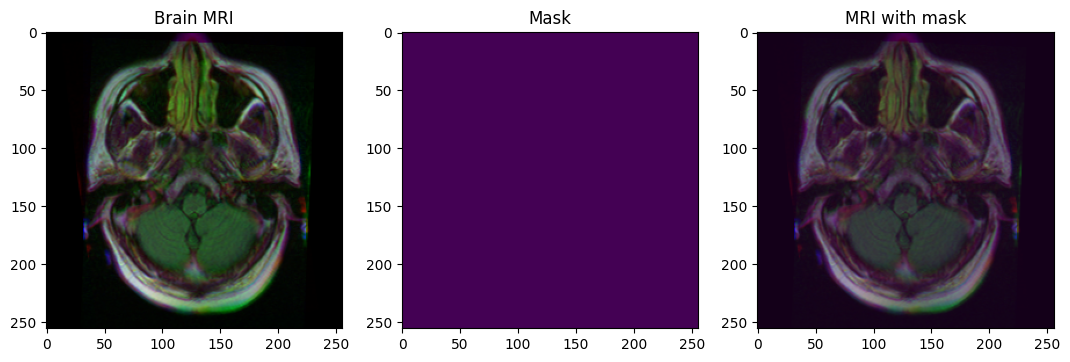

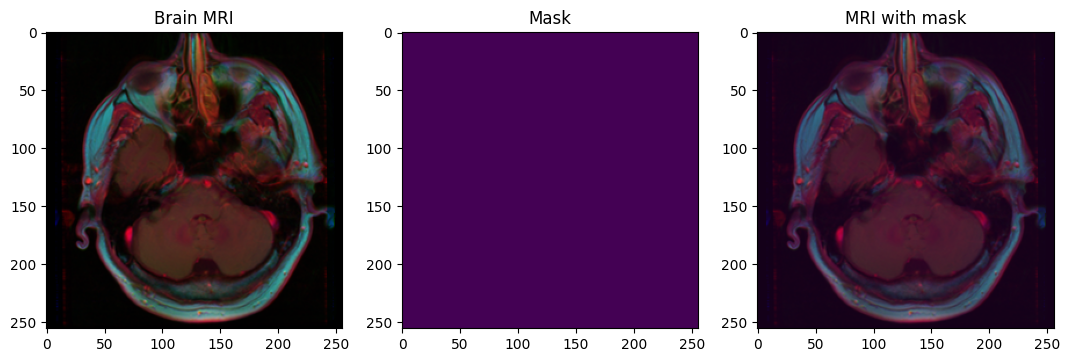

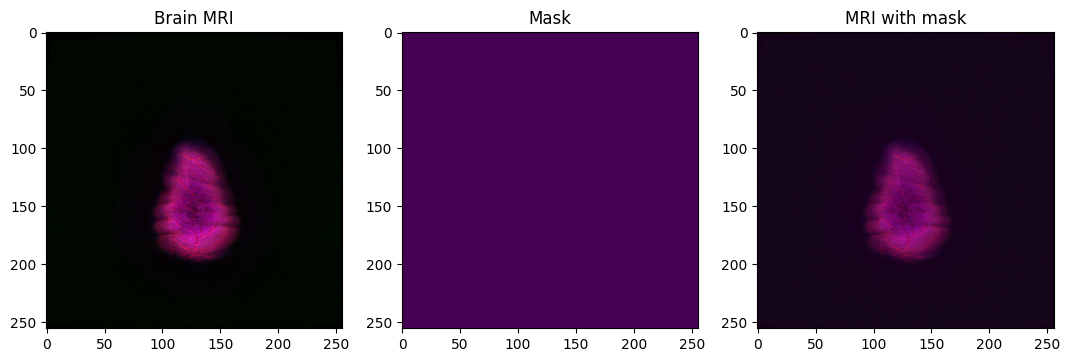

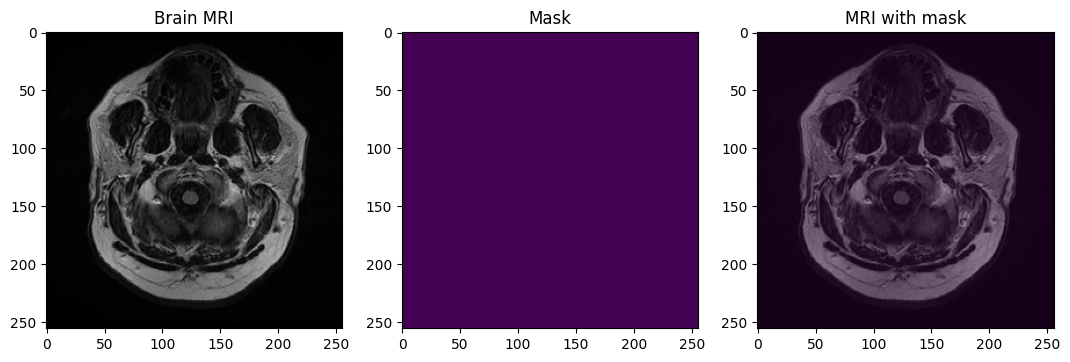

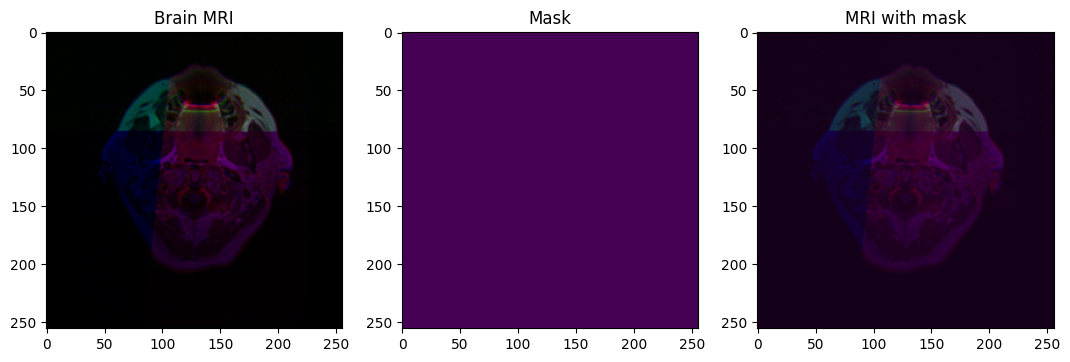

In [9]:
for i in range(5):
    plot_images(imagePath_df)

In [10]:
mask = cv2.imread(imagePath_df['directory'].iloc[10] + '/' + imagePath_df['masks'].iloc[10])

In [11]:
mask[mask == 255] = 1

In [12]:
np.expand_dims(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), -1).shape

(256, 256, 1)

In [13]:
np.expand_dims(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), -1)

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

## Протестируем генератор

In [14]:
for x, y in tf_generator(imagePath_df, 4):
    break

In [15]:
x.shape

(4, 256, 256, 3)

In [16]:
y.shape

(4, 256, 256, 1)

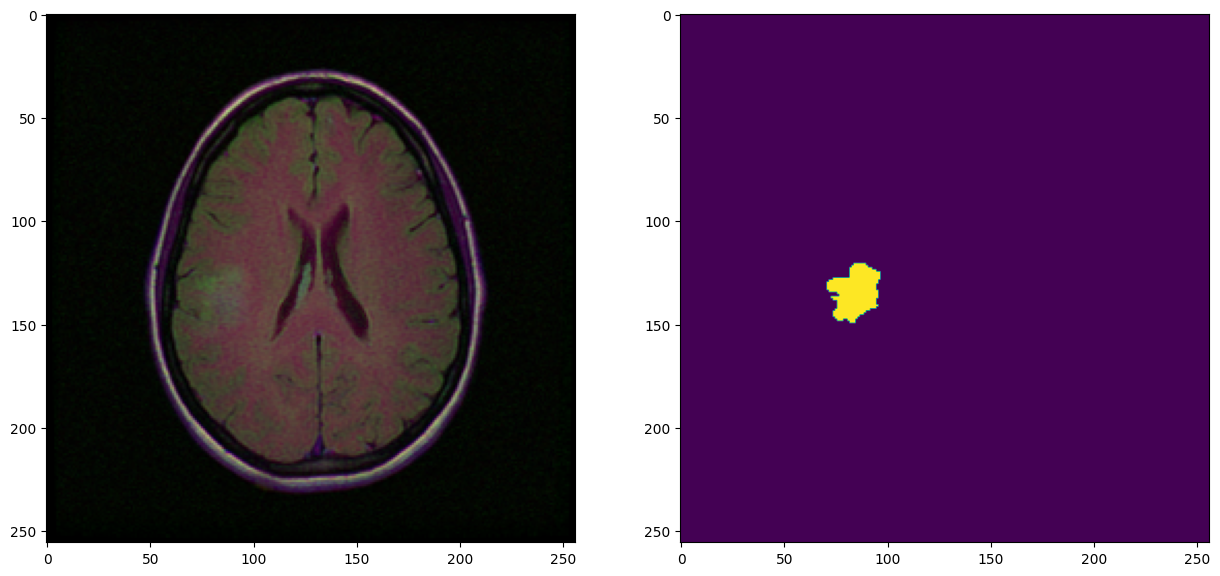

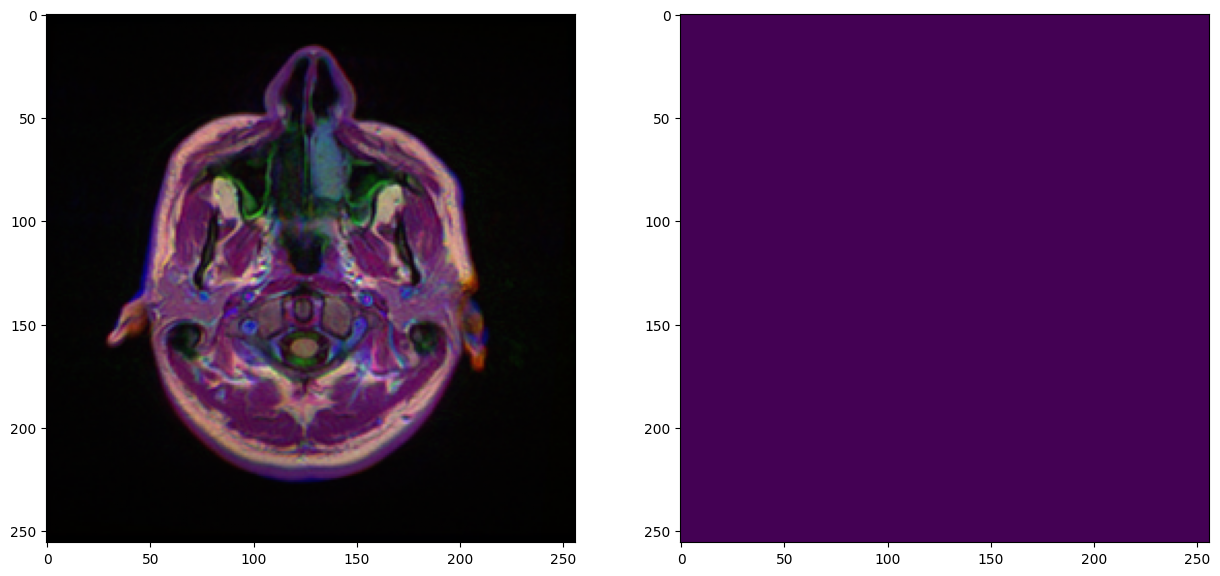

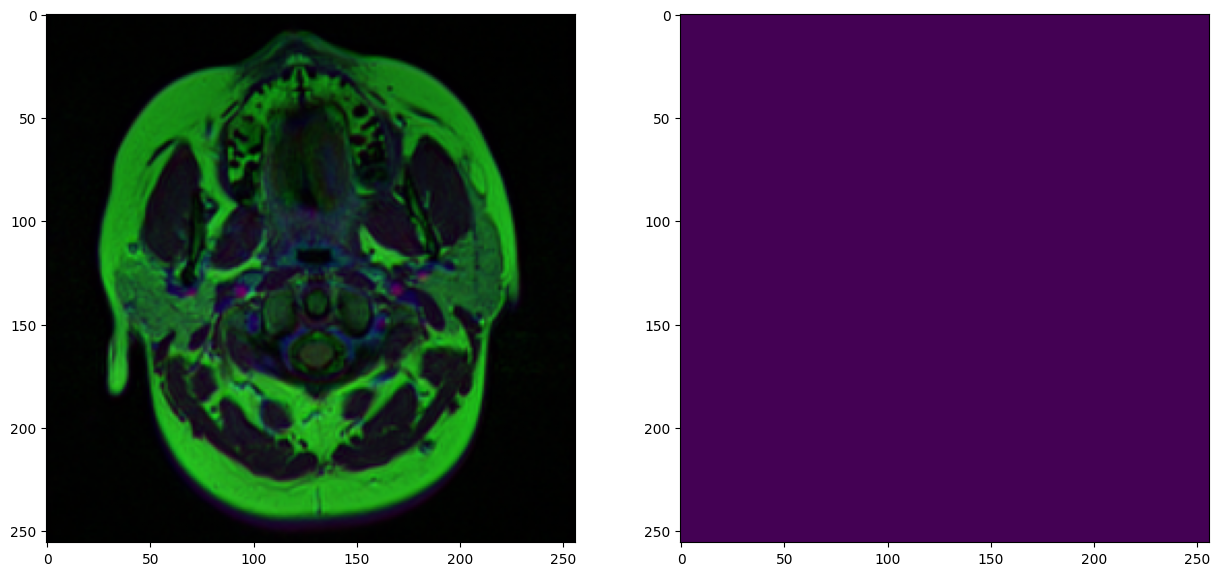

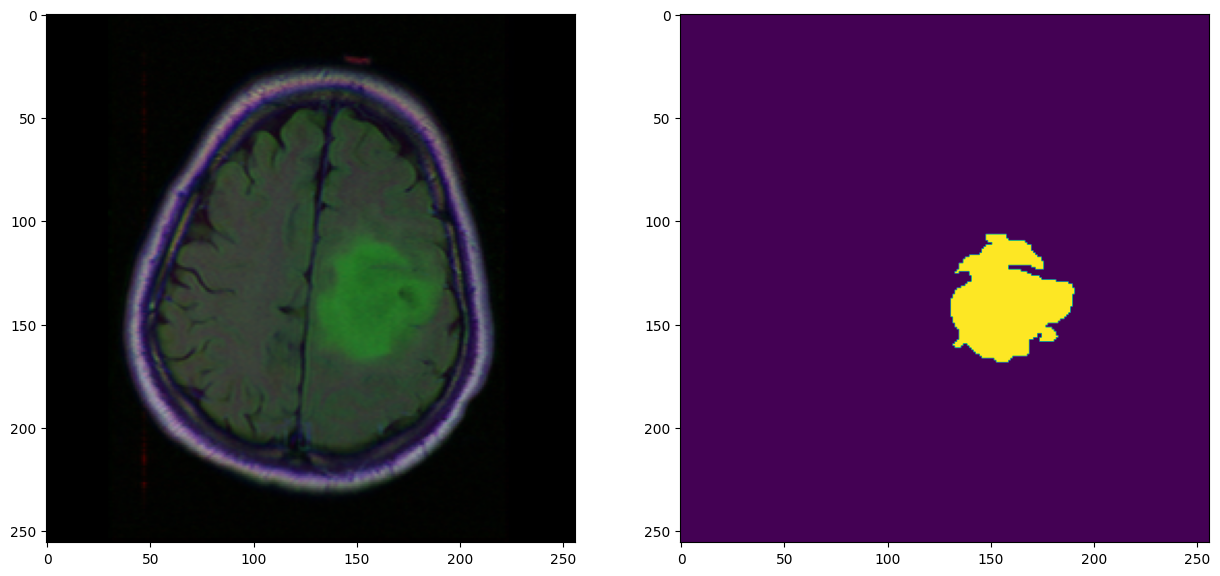

In [17]:
for i in range(4):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

    axes[0].imshow(x[i][:, :, ::-1])
    axes[1].imshow(y[i])
plt.show()

Генератора работает, теперь перейдём к архитектуре

In [18]:
y[3]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

# Разделеим все данные на тренировочные и валидационные

In [19]:
imagePath_df

directory  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                            images                              masks  class  
0     TCGA_DU_7010_19860307_56.tif  TCGA_DU_7010_19860307_56_mask.tif      0  
1      TCGA_DU_7010_19860307_8.tif   TCGA_DU_7010_19860307_8_mask.tif      0  
2     TCGA_DU_7010_19860307_34.tif  TCGA_DU_7010_19860307_34_mask.tif      1  
3     TCGA_DU_7010_19860307_33.tif  TCGA_DU_7010_19860307_33_mask.tif      1  
4     TCGA_DU_7010_19860307_43.tif  TCGA_DU_7010_19860307_43_mask.tif      1  
...                            ...                                ...    ...  
3924  TCGA_DU_7306_19930512_14.tif  TCGA_DU_7306_19930512_14_mask.tif      0  
3925  TCGA_DU_7306_19930512_42.tif  TCGA_DU_7306_19930512_42_mask.tif      0  
3926  TCGA_DU_7306_19930512_29.tif  TCGA_DU_7306_19930512_29_mask.tif      0  
3927  TCGA_DU_7306_19930512_10.tif  TCGA_DU_7306_19930512_10_mask.tif      0  
3928  TCGA_DU_7306_19930512_38.tif  TCGA_DU_7306_19930512_38_mask.tif      0  

[3929 rows x 4 columns]

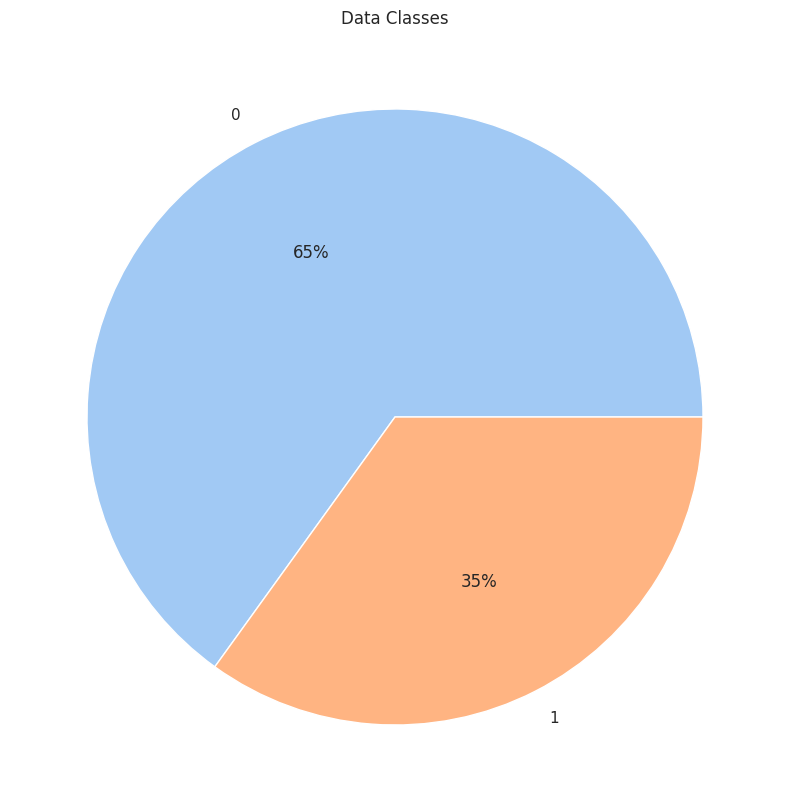

In [20]:
sns.set(rc={'figure.figsize': (10, 10)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(imagePath_df['class'].unique())
dt = np.array([len(imagePath_df[imagePath_df['class'] == i])for i in labels])
plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Data Classes')
plt.show()

In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(imagePath_df.drop(columns=['class']), imagePath_df['class'].to_numpy(),
                                                      test_size=0.15, random_state=42)

In [22]:
train_data = X_train.copy()
train_data['class'] = Y_train

valid_data = X_valid.copy()
valid_data['class'] = Y_valid

In [23]:
train_data

directory  \
152   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
889   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1539  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1052  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
102   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
1130  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1294  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
860   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3507  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3174  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                            images                              masks  class  
152    TCGA_FG_5964_20010511_1.tif   TCGA_FG_5964_20010511_1_mask.tif      0  
889   TCGA_HT_A61A_20000127_36.tif  TCGA_HT_A61A_20000127_36_mask.tif      1  
1539   TCGA_HT_7686_19950629_8.tif   TCGA_HT_7686_19950629_8_mask.tif      1  
1052   TCGA_DU_8163_19961119_9.tif   TCGA_DU_8163_19961119_9_mask.tif      0  
102    TCGA_FG_A4MT_20020212_9.tif   TCGA_FG_A4MT_20020212_9_mask.tif      1  
...                            ...                                ...    ...  
1130  TCGA_DU_7013_19860523_24.tif  TCGA_DU_7013_19860523_24_mask.tif      1  
1294   TCGA_HT_7879_19981009_9.tif   TCGA_HT_7879_19981009_9_mask.tif      1  
860   TCGA_HT_8563_19981209_13.tif  TCGA_HT_8563_19981209_13_mask.tif      1  
3507  TCGA_CS_5393_19990606_13.tif  TCGA_CS_5393_19990606_13_mask.tif      0  
3174  TCGA_DU_A5TY_19970709_27.tif  TCGA_DU_A5TY_19970709_27_mask.tif      1  

[3339 rows x 4 columns]

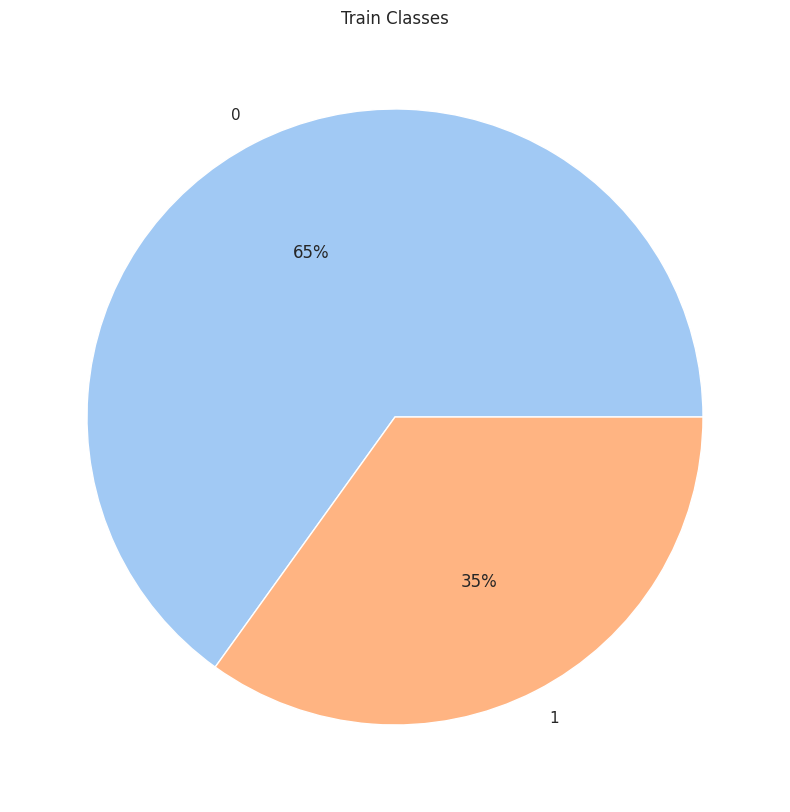

In [24]:
sns.set(rc={'figure.figsize': (10, 10)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(train_data['class'].unique())
dt = np.array([len(train_data[train_data['class'] == i])for i in labels])
plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Train Classes')
plt.show()

In [25]:
valid_data

directory  \
1835  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1490  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2063  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1178  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3749  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3737  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1233  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1027  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1814  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2535  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                            images                              masks  class  
1835   TCGA_CS_4942_19970222_2.tif   TCGA_CS_4942_19970222_2_mask.tif      0  
1490  TCGA_DU_6400_19830518_42.tif  TCGA_DU_6400_19830518_42_mask.tif      0  
2063  TCGA_FG_7637_20000922_13.tif  TCGA_FG_7637_20000922_13_mask.tif      0  
1178  TCGA_FG_8189_20030516_47.tif  TCGA_FG_8189_20030516_47_mask.tif      0  
3749   TCGA_DU_6408_19860521_7.tif   TCGA_DU_6408_19860521_7_mask.tif      0  
...                            ...                                ...    ...  
3737  TCGA_DU_6408_19860521_21.tif  TCGA_DU_6408_19860521_21_mask.tif      1  
1233  TCGA_CS_5396_20010302_14.tif  TCGA_CS_5396_20010302_14_mask.tif      1  
1027  TCGA_FG_7643_20021104_19.tif  TCGA_FG_7643_20021104_19_mask.tif      0  
1814  TCGA_DU_6399_19830416_38.tif  TCGA_DU_6399_19830416_38_mask.tif      0  
2535   TCGA_HT_7855_19951020_8.tif   TCGA_HT_7855_19951020_8_mask.tif      1  

[590 rows x 4 columns]

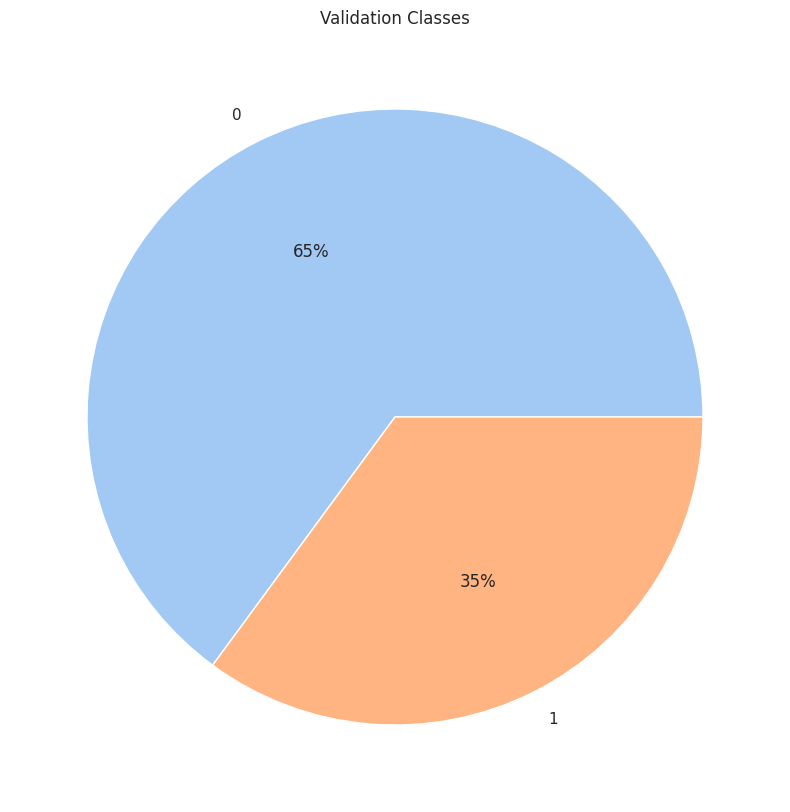

In [26]:
sns.set(rc={'figure.figsize': (10, 10)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(valid_data['class'].unique())
dt = np.array([len(valid_data[valid_data['class'] == i])for i in labels])
plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Validation Classes')
plt.show()

# U-Net model

In [27]:
print(tf.config.list_physical_devices('GPU'))

[]


In [28]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [29]:
# with tf.device('/GPU:0'):
activ_F = 'relu'
activ_out = 'softmax'

inputs = Input((256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(inputs)
conv_1_2 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conv_1_1)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(pool_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conv_2_1)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(pool_2)
conv_3_2 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conv_3_1)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(pool_3)
conv_4_2 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conv_4_1)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(pool_4)
conv_5_2 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conv_5_1)
pool_5 = MaxPooling2D(2)(conv_5_2)


up_smapling_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conc_1 = Concatenate()([conv_5_2, up_smapling_1])
conv_up_1_1 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conc_1)
conv_up_1_2 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conv_up_1_1)


up_smapling_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_4_2, up_smapling_2])
conv_up_2_1 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conc_2)
conv_up_2_2 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conv_up_2_1)


up_smapling_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_3_2, up_smapling_3])
conv_up_3_1 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conc_3)
conv_up_3_2 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conv_up_3_1)


up_smapling_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_2_2, up_smapling_4])
conv_up_4_1 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conc_4)
conv_up_4_2 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conv_up_4_1)


up_smapling_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([conv_1_2, up_smapling_5])
conv_up_5_1 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conc_5)
conv_up_5_2 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conv_up_5_1)

result = Conv2D(1, (1, 1), activation='sigmoid')(conv_up_5_2)
model = Model(inputs=inputs, outputs=result)

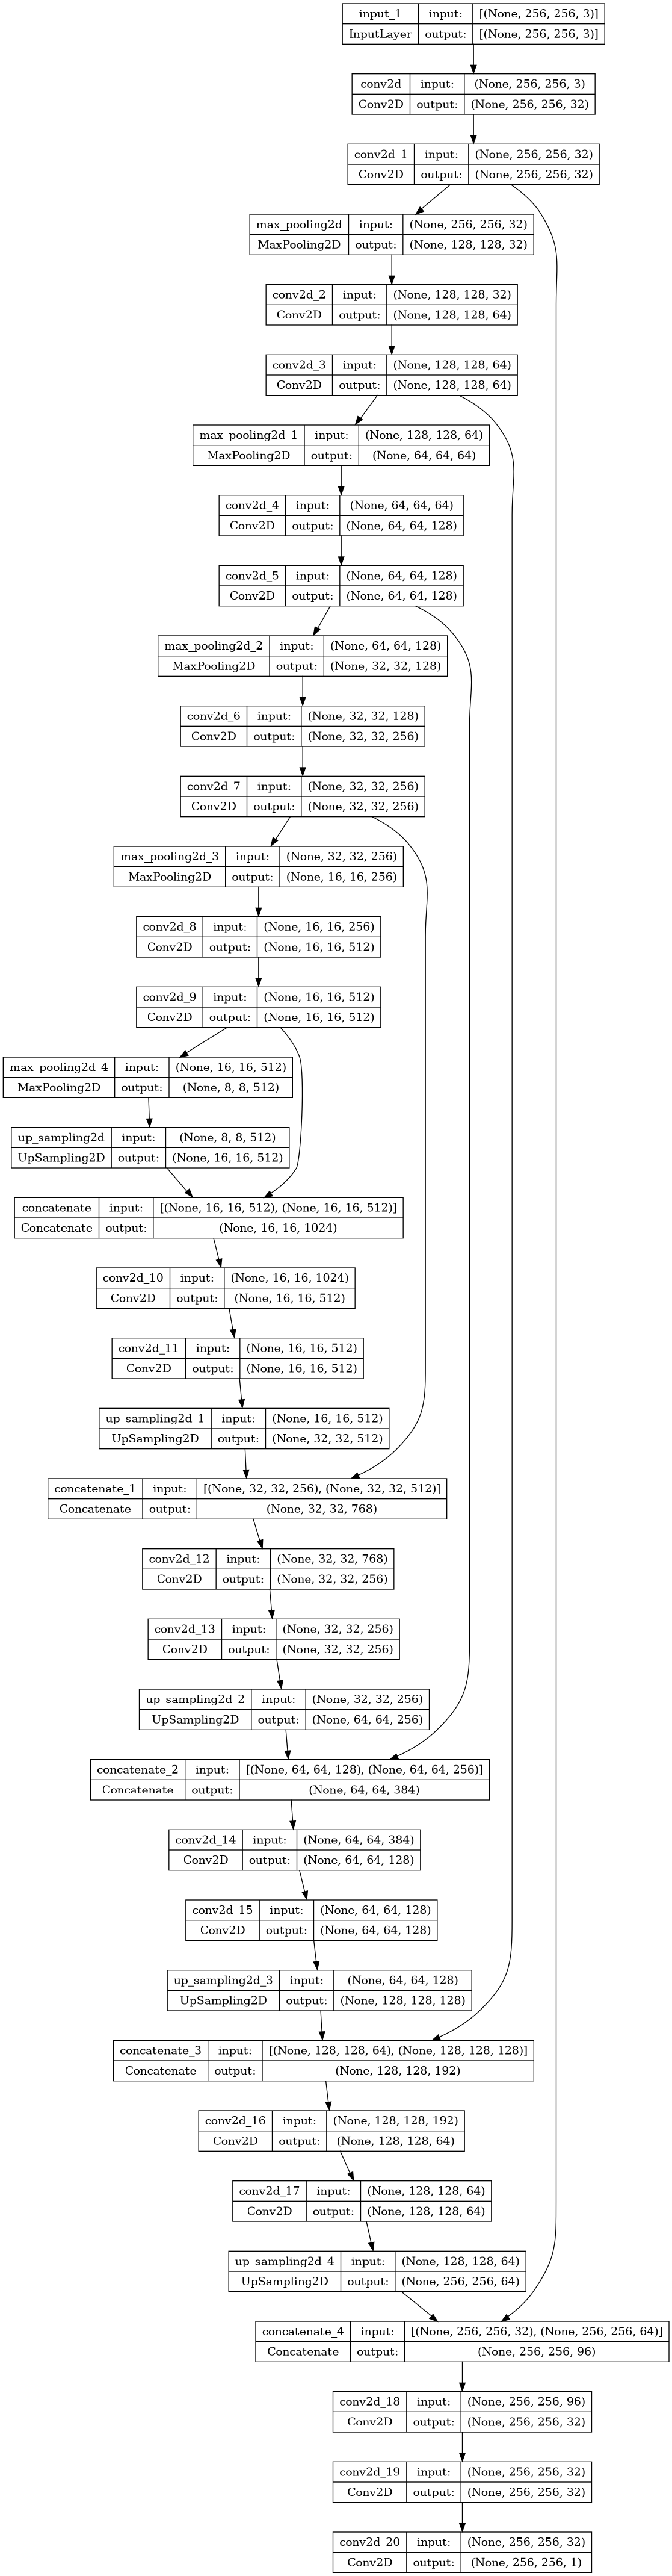

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [32]:
from tensorflow.keras.optimizers import Adam

# with tf.device('/GPU:0'):
best_w = ModelCheckpoint(
    filepath='segmintation_tenserflow_model.h5',
    verbose=1,
    save_best_only=True
)

opt = Adam(learning_rate=1e-5, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
# with tf.device('/GPU:0'):
batch_size = 32

H = model.fit(
    tf_generator(train_data, batch_size=batch_size),
    validation_data=tf_generator(valid_data, batch_size=batch_size),
    epochs=150,
    callbacks=[best_w],
    verbose=1,
    shuffle=True,
    steps_per_epoch=150,
    validation_steps=100
)

Epoch 1/150
  4/150 [..............................] - ETA: 1:38:45 - loss: 0.6919

### Посморим на результаты

#### Падение лосса

In [53]:
val_loss = H.history['loss']

Text(0.5, 1.0, 'Loss')

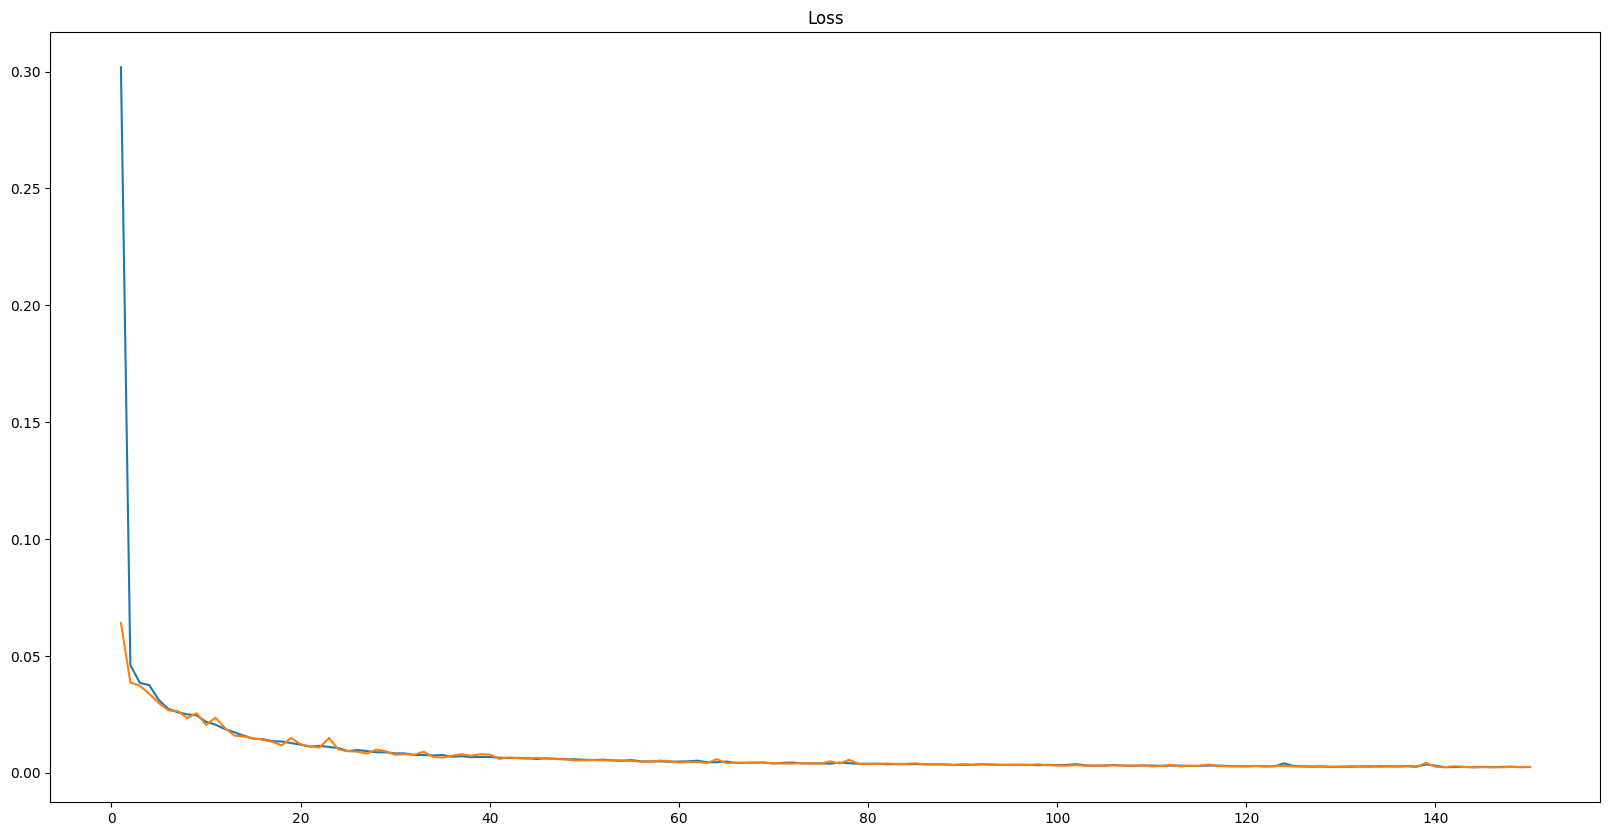

In [54]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, len(val_loss) + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, len(val_loss) + 1), H.history["val_loss"], label="vall_loss")
plt.title("Loss")

In [38]:
modelH5 = tf.keras.models.load_model("/kaggle/working/segmintation_tenserflow_model.h5")
print("Model loaded")

Model loaded


#### Визуальная проверка а так же посмотрим на IOU и MIOU

In [45]:
for x, y in tf_generator(valid_data, 16):
    break

In [46]:
pred = modelH5.predict(x)

1/1 [==============================] - 0s 29ms/step


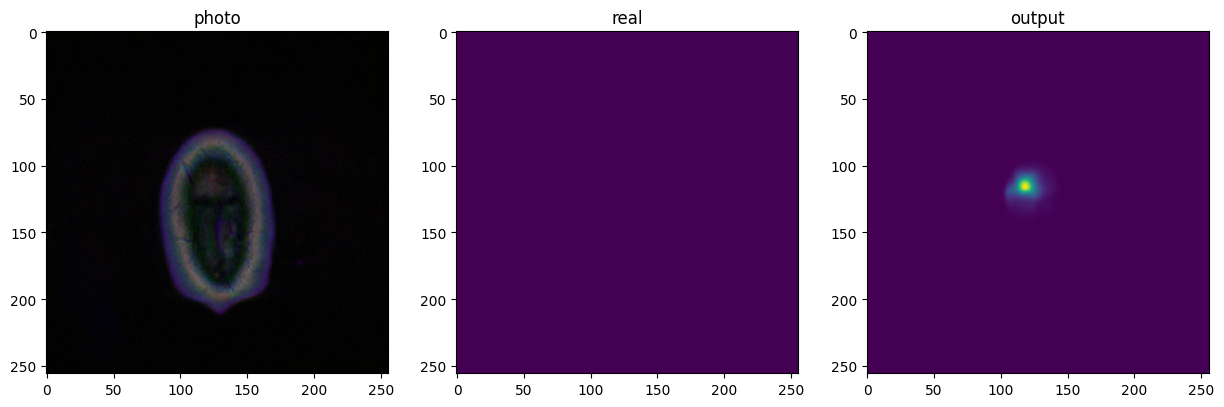

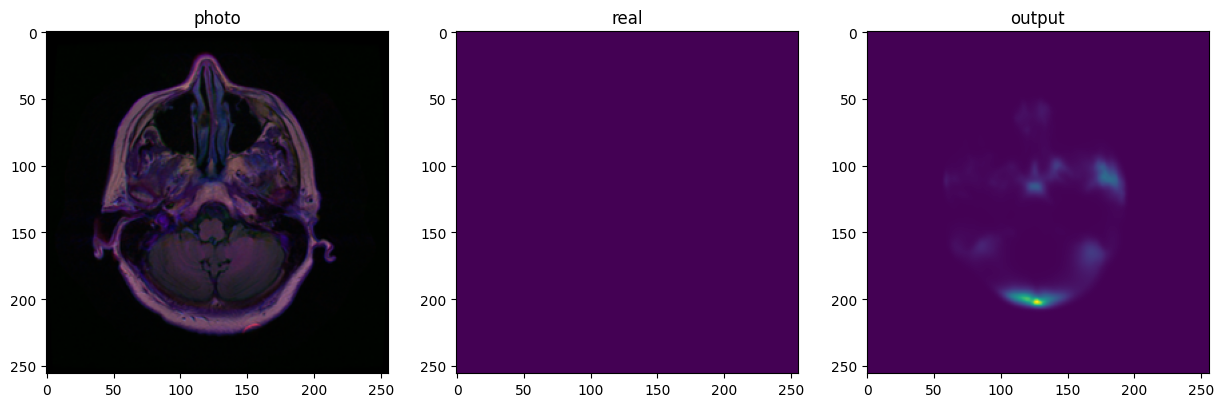

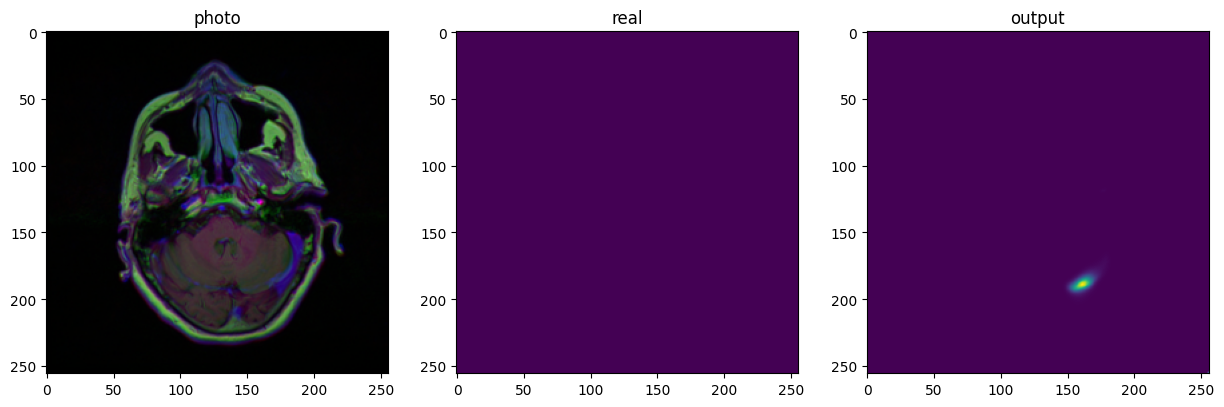

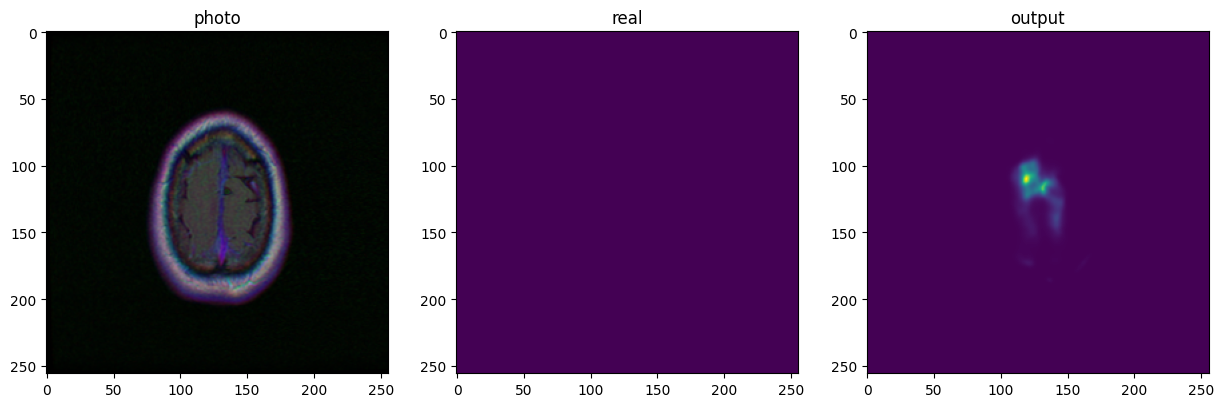

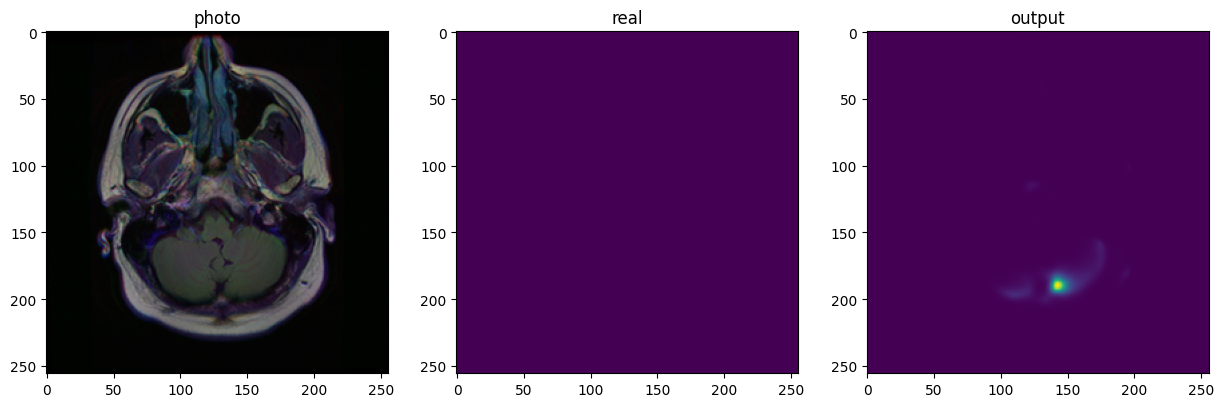

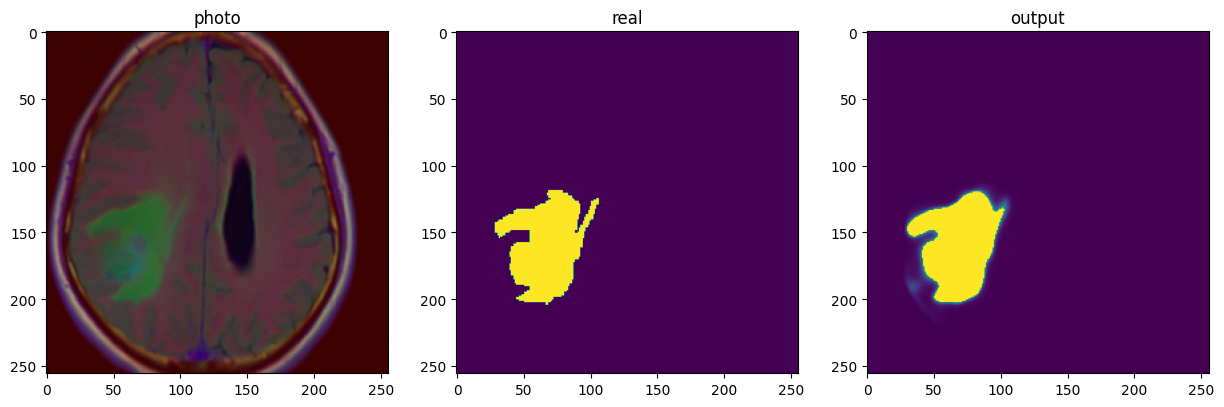

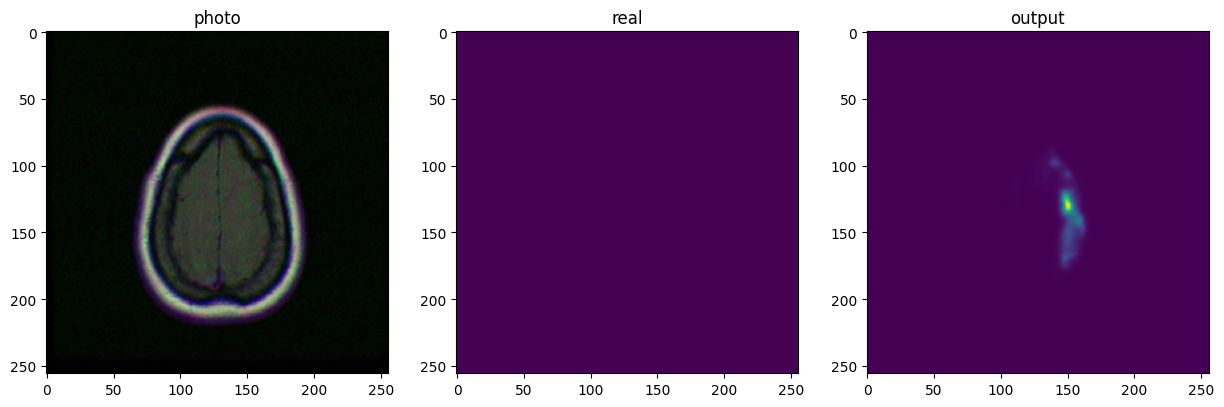

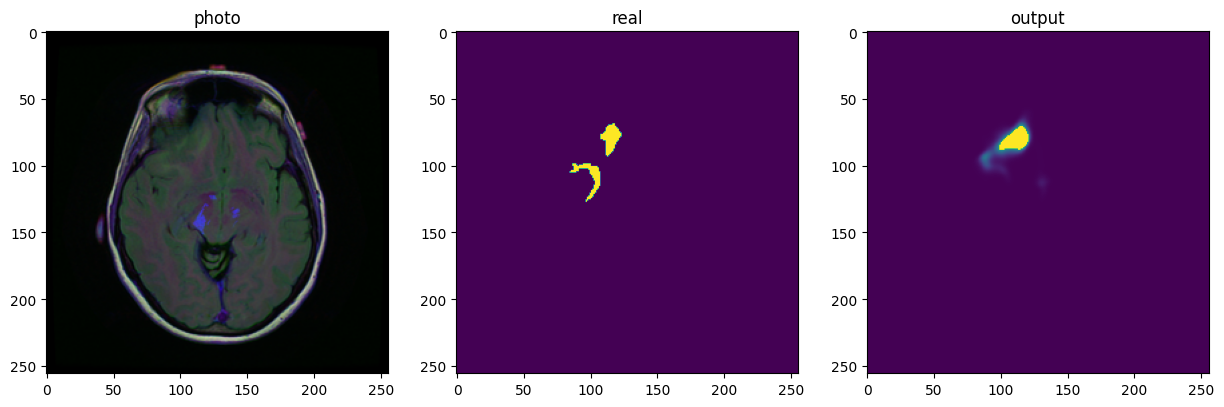

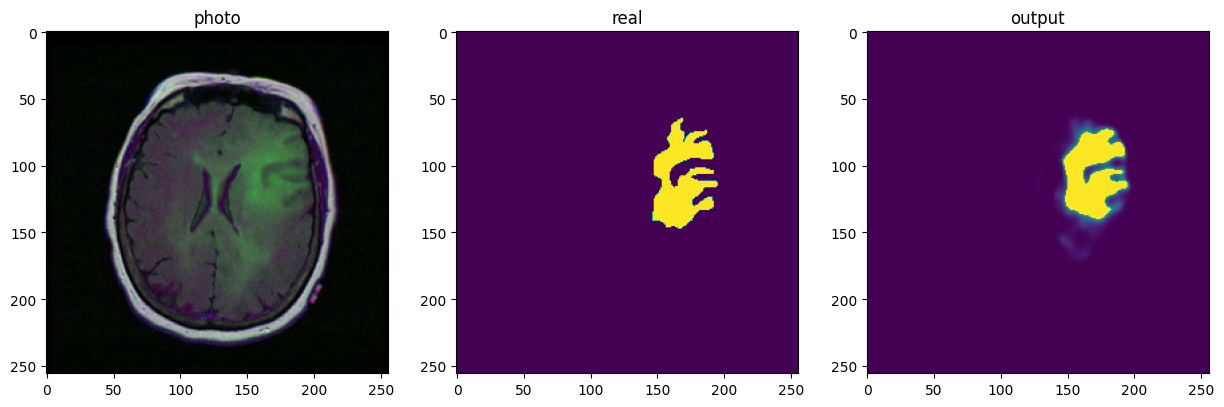

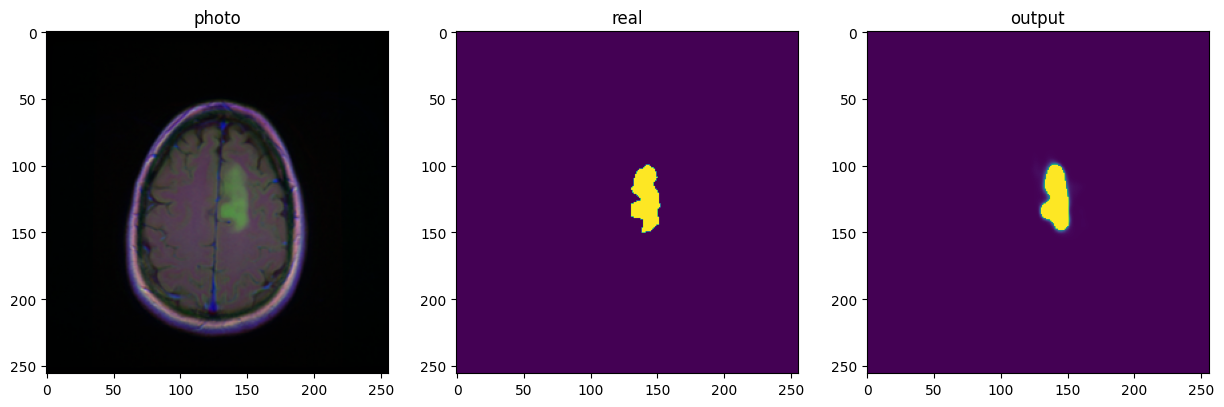

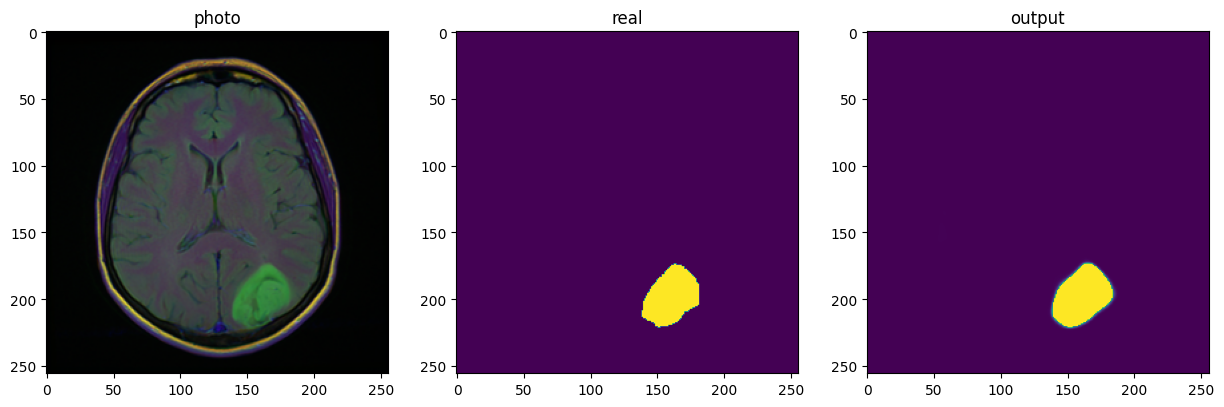

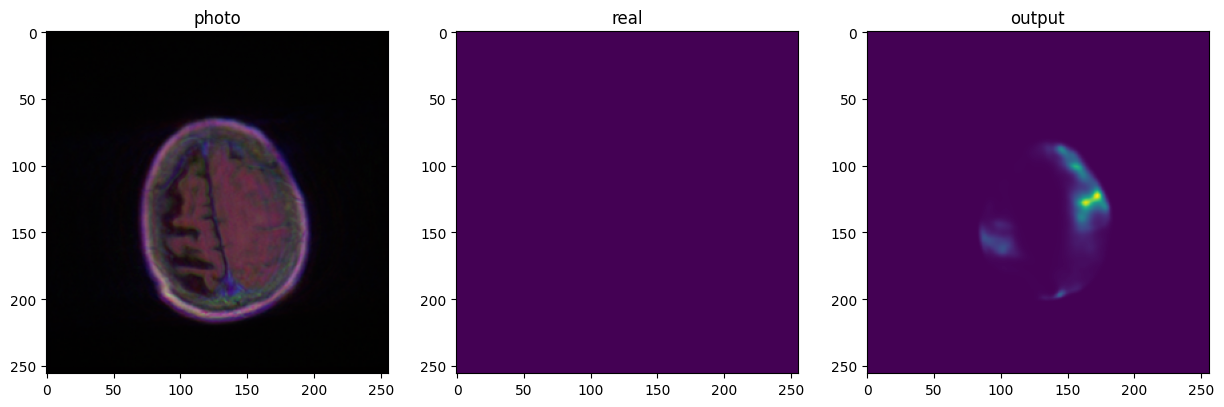

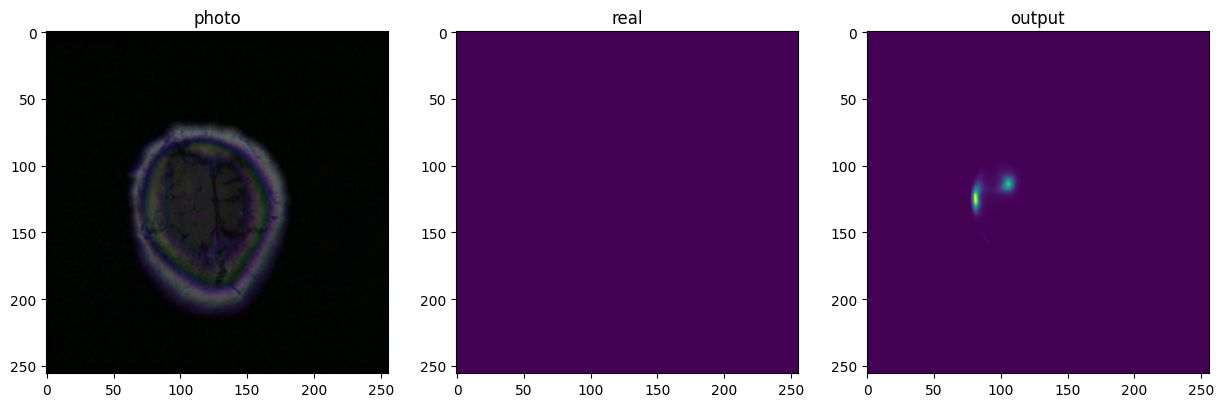

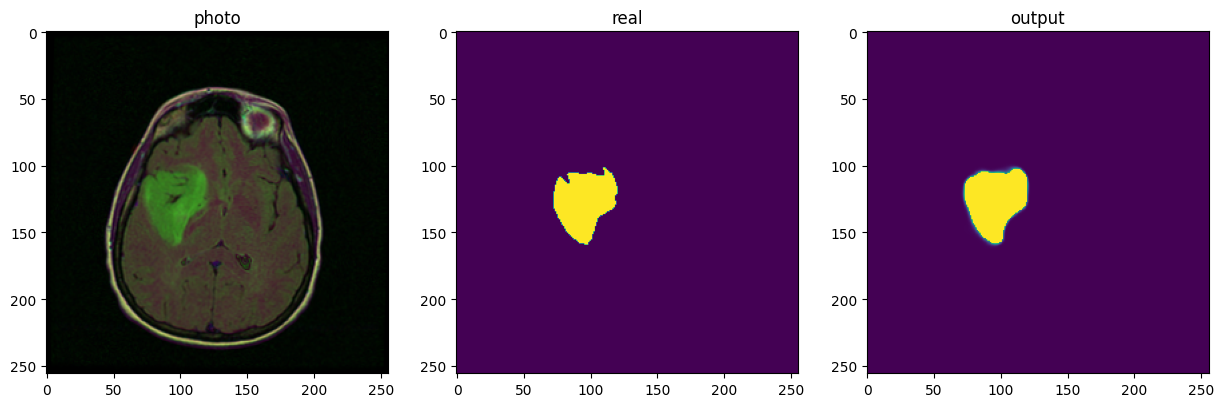

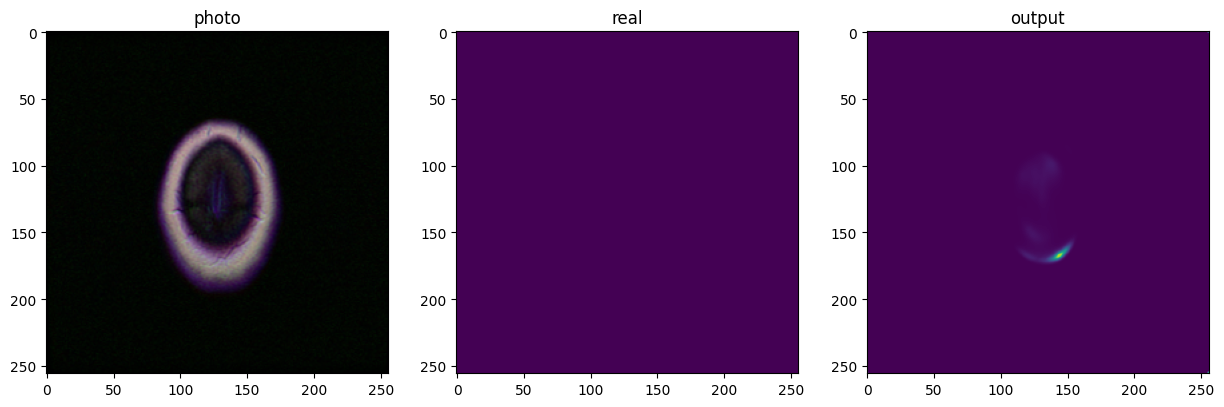

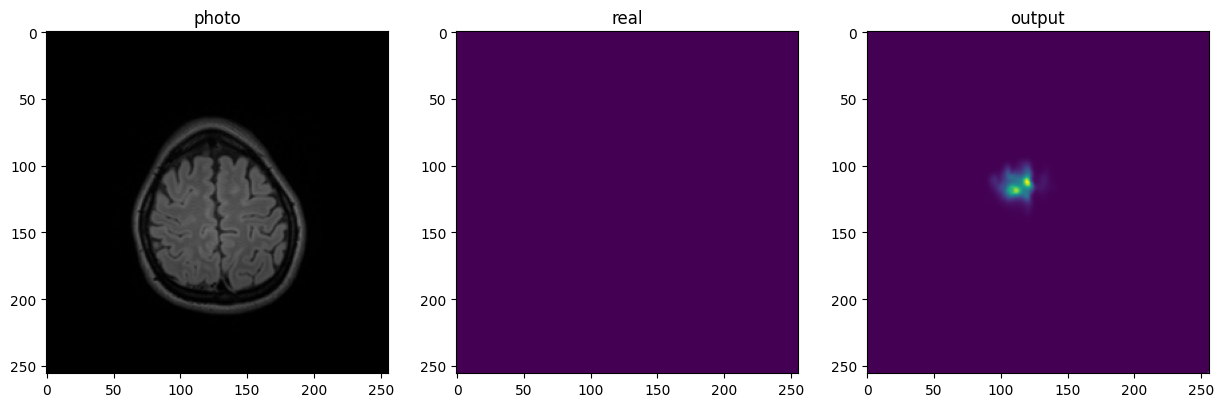

In [47]:
i = 0

for i in range(16):
    pred[i][pred[i] > 0.5] = 1
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(x[i][:, :, ::-1])
    plt.title('photo')

    plt.subplot(1, 3, 2)
    plt.imshow(y[i])
    plt.title('real')

    plt.subplot(1, 3, 3)
    plt.imshow(pred[i])
    plt.title('output')

In [42]:
data_for_pred_valid_X = []
data_for_pred_valid_Y = []
for elem in tqdm(valid_data.values):
    derictori, image, mask, _ = elem
    
    image = cv2.imread(derictori + '/' + image)
    mask = cv2.imread(derictori + '/' + mask)
    mask[mask == 255] = 1
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    data_for_pred_valid_X += [image]
    data_for_pred_valid_Y += [mask]
data_for_pred_valid_X = np.array(data_for_pred_valid_X) / 255.
data_for_pred_valid_Y = np.expand_dims(np.array(data_for_pred_valid_Y), -1)
predict_data = []
for elem in modelH5.predict(data_for_pred_valid_X):
    elem[elem > 0.5] = 1
    predict_data.append(elem)
predict_data = np.array(predict_data)

100%|██████████| 393/393 [00:01<00:00, 255.29it/s]


13/13 [==============================] - 5s 405ms/step


In [43]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_true=data_for_pred_valid_Y, y_pred=predict_data)
print(f'MeanIoU = {m.result().numpy()}')

MeanIoU = 0.923471212387085


In [44]:
m = tf.keras.metrics.IoU(target_class_ids=[0, 1], num_classes=2)
m.update_state(y_true=data_for_pred_valid_Y, y_pred=predict_data)
print(f'IoU = {m.result().numpy()}')

IoU = 0.923471212387085
